# exp110_相対座標ML

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 


In [2]:
g1 = ['2020-05-14-US-MTV-1', '2020-05-14-US-MTV-2', '2020-05-21-US-MTV-1', '2020-05-21-US-MTV-2',
      '2020-05-29-US-MTV-1', '2020-05-29-US-MTV-2', '2020-06-04-US-MTV-1', '2020-06-05-US-MTV-1',
      '2020-06-05-US-MTV-2', '2020-06-11-US-MTV-1', '2020-07-08-US-MTV-1', '2020-07-17-US-MTV-1',
      '2020-07-17-US-MTV-2', '2020-08-03-US-MTV-1', '2020-08-06-US-MTV-2', '2020-09-04-US-SF-1',
      '2020-09-04-US-SF-2',  '2021-01-04-US-RWC-1', '2021-01-04-US-RWC-2',
      '2020-05-15-US-MTV-1', '2020-05-28-US-MTV-1', '2020-05-28-US-MTV-2', '2020-06-04-US-MTV-2',
      '2020-06-10-US-MTV-1', '2020-06-10-US-MTV-2', '2020-08-03-US-MTV-2', '2020-08-13-US-MTV-1',
      '2021-03-16-US-MTV-2']

g2 = ['2021-01-05-US-SVL-1', '2021-01-05-US-SVL-2', '2021-04-15-US-MTV-1', 
      '2021-03-25-US-PAO-1', '2021-04-02-US-SJC-1', '2021-04-08-US-MTV-1']

g3 = ['2021-03-10-US-SVL-1', '2021-04-26-US-SVL-1', '2021-04-26-US-SVL-2']

g4 = ['2021-04-28-US-MTV-1', '2021-04-29-US-MTV-1', 
      '2021-03-16-US-RWC-2', '2021-04-21-US-MTV-1', '2021-04-28-US-MTV-2', '2021-04-29-US-MTV-2']

g5 = ['2021-04-22-US-SJC-1', '2021-04-28-US-SJC-1', '2021-04-29-US-SJC-2', 
      '2021-04-22-US-SJC-2', '2021-04-29-US-SJC-3']

In [3]:
target = g5

In [4]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [5]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [6]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [7]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [8]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [9]:
# ground_truth
def get_ground_truth():
    return pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

In [10]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [11]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [12]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [13]:
def get_train_test_data(train_test):
    dist = pd.read_csv(f'../output/prep/distance_pred_v002_features/{train_test}_distance_pred.csv')
    deg = pd.read_csv(f'../output/prep/degree_pred_v002_features/{train_test}_degree_pred.csv')
    df = pd.read_csv(INPUT + '/' + f'baseline_locations_{train_test}.csv')
    
    if train_test == 'train':
        dist.drop(columns=['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM', 'speedMps'], inplace=True)
        deg.drop(columns=['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'latDeg_gt', 'lngDeg_gt', 'courseDegree', 'secondSinceGpsEpoch', 'heightAboveWgs84EllipsoidM', 'speedMps', 'deg'], inplace=True)
    if train_test == 'test':
        dist.drop(columns=['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], inplace=True)
        deg.drop(columns=['collectionName', 'phoneName', 'latDeg', 'lngDeg', 'secondSinceGpsEpoch', 'heightAboveWgs84EllipsoidM'], inplace=True)
    dist = dist.rename(columns={'pred':'dist_pred'})
    
    
    df = df.merge(dist, on=['phone', 'millisSinceGpsEpoch'], how='left')
    df = df.merge(deg, on=['phone', 'millisSinceGpsEpoch'], how='left')
    
    return df

In [14]:
def add_label(df):
    gt = get_ground_truth()
    df[['latDeg_gt', 'lngDeg_gt']] = gt[['latDeg', 'lngDeg']]
    df['latDeg_diff'] = df['latDeg_gt'].shift(-1) - df['latDeg_gt']
    df['lngDeg_diff'] = df['lngDeg_gt'].shift(-1) - df['lngDeg_gt']
    df.loc[df['phone']!=df['phone'].shift(-1), ['latDeg_diff', 'lngDeg_diff']] = np.nan
    df = df.dropna(subset=['latDeg_diff', 'lngDeg_diff'])
    return df

In [15]:
def add_features(df):
    for c, i in itertools.product(['dist_pred', 'calc_deg'], [1,2,3,4,5-1,-2,-3,-4,-5]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    return df

# データ準備

In [16]:
train = get_train_test_data('train')
train = add_label(train)
train = add_features(train)

test = get_train_test_data('test')
test = add_features(test)

In [17]:
train = train[train['collectionName'].isin(target)].copy()
train = train.reset_index(drop=True)
test = test[test['collectionName'].isin(target)].copy()
test = test.reset_index(drop=True)

In [18]:
targets= ['latDeg_diff', 'lngDeg_diff']
not_use_cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone', 
                'latDeg_gt', 'lngDeg_gt']
not_use_cols = not_use_cols + targets
features = [c for c in train.columns if c not in not_use_cols]

params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.1, 
          'seed': 42}

# lgb_tune

In [19]:
collections = train['collectionName'].unique()

target = targets[0]
collection = collections[0]

tr_idx = train[train['collectionName']!=collection].index
vl_idx = train[train['collectionName']==collection].index
tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
tr_data = lgb.Dataset(tr_x, label=tr_y)
vl_data = lgb.Dataset(vl_x, label=vl_y)

model = optuna_lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                         num_boost_round=20000, early_stopping_rounds=100, verbose_eval=-1)

[I 2021-07-11 22:35:25,917] A new study created in memory with name: no-name-9e1e5d5e-2751-4970-ac89-600632effd11
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  14%|#4        | 1/7 [00:06<00:41,  6.85s/it]

Early stopping, best iteration is:
[434]	valid_0's rmse: 4.96934e-07	valid_1's rmse: 6.6445e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  29%|##8       | 2/7 [00:14<00:36,  7.30s/it]

Early stopping, best iteration is:
[220]	valid_0's rmse: 1.14426e-06	valid_1's rmse: 6.86859e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  43%|####2     | 3/7 [00:23<00:32,  8.12s/it]

Early stopping, best iteration is:
[453]	valid_0's rmse: 4.31752e-07	valid_1's rmse: 6.65193e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  57%|#####7    | 4/7 [00:39<00:33, 11.29s/it]

Early stopping, best iteration is:
[818]	valid_0's rmse: 1.29294e-07	valid_1's rmse: 6.643e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  71%|#######1  | 5/7 [00:41<00:15,  7.95s/it]

Early stopping, best iteration is:
[142]	valid_0's rmse: 1.64023e-06	valid_1's rmse: 6.98781e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.000007:  86%|########5 | 6/7 [01:04<00:12, 12.91s/it]

Early stopping, best iteration is:
[783]	valid_0's rmse: 1.25479e-07	valid_1's rmse: 6.91126e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[319]	valid_0's rmse: 7.23486e-07	valid_1's rmse: 6.87968e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:   5%|5         | 1/20 [00:08<02:48,  8.87s/it]

Early stopping, best iteration is:
[99]	valid_0's rmse: 8.05295e-07	valid_1's rmse: 6.78477e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  10%|#         | 2/20 [00:35<05:46, 19.26s/it]

Early stopping, best iteration is:
[75]	valid_0's rmse: 7.42331e-07	valid_1's rmse: 6.91197e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  15%|#5        | 3/20 [00:52<05:07, 18.09s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 7.78546e-07	valid_1's rmse: 6.92501e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  20%|##        | 4/20 [01:08<04:37, 17.34s/it]

Early stopping, best iteration is:
[83]	valid_0's rmse: 6.30033e-07	valid_1's rmse: 6.9502e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  25%|##5       | 5/20 [01:39<05:34, 22.30s/it]

Early stopping, best iteration is:
[277]	valid_0's rmse: 2.52876e-07	valid_1's rmse: 6.91282e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  30%|###       | 6/20 [02:31<07:32, 32.34s/it]

Early stopping, best iteration is:
[335]	valid_0's rmse: 1.96392e-07	valid_1's rmse: 6.90246e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  35%|###5      | 7/20 [03:03<07:01, 32.44s/it]

Early stopping, best iteration is:
[134]	valid_0's rmse: 8.8366e-07	valid_1's rmse: 6.73058e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  40%|####      | 8/20 [05:17<12:56, 64.68s/it]

Early stopping, best iteration is:
[292]	valid_0's rmse: 2.51391e-07	valid_1's rmse: 6.89584e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  45%|####5     | 9/20 [05:53<10:12, 55.64s/it]

Early stopping, best iteration is:
[95]	valid_0's rmse: 8.57974e-07	valid_1's rmse: 6.76854e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000007:  50%|#####     | 10/20 [08:27<14:20, 86.02s/it]

Early stopping, best iteration is:
[212]	valid_0's rmse: 3.19619e-07	valid_1's rmse: 6.9436e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  55%|#####5    | 11/20 [08:52<10:05, 67.29s/it]

Early stopping, best iteration is:
[612]	valid_0's rmse: 9.96155e-07	valid_1's rmse: 6.41296e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  60%|######    | 12/20 [09:29<07:45, 58.22s/it]

Early stopping, best iteration is:
[3064]	valid_0's rmse: 2.68753e-06	valid_1's rmse: 7.45342e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  65%|######5   | 13/20 [09:53<05:34, 47.78s/it]

Early stopping, best iteration is:
[975]	valid_0's rmse: 1.20237e-06	valid_1's rmse: 6.45672e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  70%|#######   | 14/20 [10:29<04:24, 44.17s/it]

Early stopping, best iteration is:
[643]	valid_0's rmse: 6.81036e-07	valid_1's rmse: 6.50695e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  75%|#######5  | 15/20 [10:58<03:18, 39.67s/it]

Early stopping, best iteration is:
[203]	valid_0's rmse: 9.50905e-07	valid_1's rmse: 6.73322e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  80%|########  | 16/20 [10:59<01:52, 28.11s/it]

Early stopping, best iteration is:
[198]	valid_0's rmse: 1.02551e-05	valid_1's rmse: 1.18105e-05
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  85%|########5 | 17/20 [11:56<01:49, 36.61s/it]

Early stopping, best iteration is:
[512]	valid_0's rmse: 1.41799e-07	valid_1's rmse: 6.72243e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  90%|######### | 18/20 [12:36<01:15, 37.74s/it]

Early stopping, best iteration is:
[80]	valid_0's rmse: 1.09519e-06	valid_1's rmse: 6.83058e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.000006:  95%|#########5| 19/20 [13:22<00:40, 40.09s/it]

Early stopping, best iteration is:
[794]	valid_0's rmse: 2.98589e-07	valid_1's rmse: 6.68334e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[71]	valid_0's rmse: 9.28524e-07	valid_1's rmse: 6.84184e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  10%|#         | 1/10 [00:40<06:04, 40.54s/it]

Early stopping, best iteration is:
[684]	valid_0's rmse: 9.94536e-07	valid_1's rmse: 6.62798e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  20%|##        | 2/10 [01:20<05:19, 39.90s/it]

Early stopping, best iteration is:
[1031]	valid_0's rmse: 5.2655e-07	valid_1's rmse: 6.77258e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  30%|###       | 3/10 [01:45<03:53, 33.39s/it]

Early stopping, best iteration is:
[703]	valid_0's rmse: 9.53888e-07	valid_1's rmse: 6.87783e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  40%|####      | 4/10 [02:06<02:51, 28.62s/it]

Early stopping, best iteration is:
[391]	valid_0's rmse: 1.89484e-06	valid_1's rmse: 6.74745e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  50%|#####     | 5/10 [02:48<02:46, 33.33s/it]

Early stopping, best iteration is:
[792]	valid_0's rmse: 7.15792e-07	valid_1's rmse: 6.55256e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  60%|######    | 6/10 [03:20<02:11, 32.86s/it]

Early stopping, best iteration is:
[829]	valid_0's rmse: 7.63848e-07	valid_1's rmse: 6.57513e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  70%|#######   | 7/10 [04:01<01:46, 35.56s/it]

Early stopping, best iteration is:
[1086]	valid_0's rmse: 4.24986e-07	valid_1's rmse: 6.51081e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  80%|########  | 8/10 [04:27<01:05, 32.60s/it]

Early stopping, best iteration is:
[409]	valid_0's rmse: 1.65479e-06	valid_1's rmse: 6.67255e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.000006:  90%|######### | 9/10 [04:59<00:32, 32.22s/it]

Early stopping, best iteration is:
[740]	valid_0's rmse: 8.19842e-07	valid_1's rmse: 6.65301e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[519]	valid_0's rmse: 1.19483e-06	valid_1's rmse: 6.56672e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:  17%|#6        | 1/6 [00:33<02:45, 33.18s/it]

Early stopping, best iteration is:
[971]	valid_0's rmse: 5.53493e-07	valid_1's rmse: 6.56118e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:  33%|###3      | 2/6 [01:17<02:39, 39.91s/it]

Early stopping, best iteration is:
[873]	valid_0's rmse: 6.15578e-07	valid_1's rmse: 6.44742e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:  50%|#####     | 3/6 [01:38<01:34, 31.33s/it]

Early stopping, best iteration is:
[592]	valid_0's rmse: 1.02226e-06	valid_1's rmse: 6.49512e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:  67%|######6   | 4/6 [02:02<00:56, 28.10s/it]

Early stopping, best iteration is:
[526]	valid_0's rmse: 1.14905e-06	valid_1's rmse: 6.48267e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.000006:  83%|########3 | 5/6 [02:32<00:28, 28.83s/it]

Early stopping, best iteration is:
[730]	valid_0's rmse: 8.08638e-07	valid_1's rmse: 6.51613e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.000006:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[551]	valid_0's rmse: 1.12277e-06	valid_1's rmse: 6.59978e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no mo

regularization_factors, val_score: 0.000006:   5%|5         | 1/20 [00:05<01:53,  5.98s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

regularization_factors, val_score: 0.000006:  10%|#         | 2/20 [00:06<00:51,  2.85s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


regularization_factors, val_score: 0.000006:  15%|#5        | 3/20 [00:29<03:26, 12.14s/it]

Early stopping, best iteration is:
[516]	valid_0's rmse: 1.24507e-06	valid_1's rmse: 6.59849e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.000006:  20%|##        | 4/20 [01:25<07:49, 29.33s/it]

Early stopping, best iteration is:
[1494]	valid_0's rmse: 2.32776e-07	valid_1's rmse: 6.38885e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

regularization_factors, val_score: 0.000006:  25%|##5       | 5/20 [01:27<04:53, 19.54s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

regularization_factors, val_score: 0.000006:  30%|###       | 6/20 [01:53<05:01, 21.51s/it]

Early stopping, best iteration is:
[638]	valid_0's rmse: 9.3552e-07	valid_1's rmse: 6.3897e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.000006:  35%|###5      | 7/20 [02:32<05:57, 27.47s/it]

Early stopping, best iteration is:
[748]	valid_0's rmse: 1.29007e-06	valid_1's rmse: 6.37531e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.000006:  40%|####      | 8/20 [02:39<04:10, 20.86s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

regularization_factors, val_score: 0.000006:  45%|####5     | 9/20 [03:12<04:32, 24.81s/it]

Early stopping, best iteration is:
[940]	valid_0's rmse: 5.58181e-07	valid_1's rmse: 6.43662e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no mo

regularization_factors, val_score: 0.000006:  50%|#####     | 10/20 [03:18<03:07, 18.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

regularization_factors, val_score: 0.000006:  55%|#####5    | 11/20 [03:41<03:02, 20.29s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

regularization_factors, val_score: 0.000006:  60%|######    | 12/20 [04:21<03:28, 26.01s/it]

Early stopping, best iteration is:
[963]	valid_0's rmse: 7.44606e-07	valid_1's rmse: 6.45402e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

regularization_factors, val_score: 0.000006:  65%|######5   | 13/20 [04:27<02:20, 20.10s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


regularization_factors, val_score: 0.000006:  70%|#######   | 14/20 [05:14<02:48, 28.16s/it]

Early stopping, best iteration is:
[1139]	valid_0's rmse: 4.38949e-07	valid_1's rmse: 6.41892e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.000006:  75%|#######5  | 15/20 [06:29<03:31, 42.38s/it]

Early stopping, best iteration is:
[1965]	valid_0's rmse: 1.17793e-07	valid_1's rmse: 6.39706e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

regularization_factors, val_score: 0.000006:  80%|########  | 16/20 [06:36<02:06, 31.61s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


regularization_factors, val_score: 0.000006:  85%|########5 | 17/20 [07:33<01:57, 39.29s/it]

Early stopping, best iteration is:
[1569]	valid_0's rmse: 2.04957e-07	valid_1's rmse: 6.39765e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.000006:  90%|######### | 18/20 [08:14<01:19, 39.68s/it]

Early stopping, best iteration is:
[756]	valid_0's rmse: 7.70902e-07	valid_1's rmse: 6.40299e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

regularization_factors, val_score: 0.000006:  95%|#########5| 19/20 [08:52<00:39, 39.27s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


min_data_in_leaf, val_score: 0.000006:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[557]	valid_0's rmse: 1.08003e-06	valid_1's rmse: 6.41025e-06
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

min_data_in_leaf, val_score: 0.000006:  20%|##        | 1/5 [00:30<02:01, 30.38s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

min_data_in_leaf, val_score: 0.000006:  40%|####      | 2/5 [01:10<01:49, 36.39s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

min_data_in_leaf, val_score: 0.000006:  60%|######    | 3/5 [01:42<01:08, 34.15s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

min_data_in_leaf, val_score: 0.000006:  80%|########  | 4/5 [02:12<00:32, 32.60s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

min_data_in_leaf, val_score: 0.000006: 100%|##########| 5/5 [02:47<00:00, 33.57s/it]


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


In [20]:
opt_params = model.params

In [21]:
print(opt_params)

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.1, 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 6.485905199263506e-05, 'lambda_l2': 1.7288723295067412e-08, 'num_leaves': 15, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 20000, 'early_stopping_round': 100}


# 学習

In [23]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()

test[targets[0] + '_pred'] = 0
test[targets[1] + '_pred'] = 0
n = len(collections)

for collection in collections:
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x = train[features].iloc[tr_idx]
    vl_x = train[features].iloc[vl_idx]
    oof_tmp = train.iloc[vl_idx].copy()
    
    for target in targets:
        print('valid : ', collection)
        tr_y = train[target].iloc[tr_idx]
        vl_y = train[target].iloc[vl_idx]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                          num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)

        vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof_tmp[target + '_pred'] = vl_pred

        imp_tmp = pd.DataFrame()
        imp_tmp['feature'] = model.feature_name()
        imp_tmp['importance'] = model.feature_importance()
        imp_tmp['valid_collection'] = collection
        imp_tmp['target'] = target
        imp = imp.append(imp_tmp)

        pred = model.predict(test[features], num_iteration=model.best_iteration)
        test[target + '_pred'] += pred / n
    oof = oof.append(oof_tmp)

valid :  2021-04-22-US-SJC-1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127758
[LightGBM] [Info] Number of data points in the train set: 8793, number of used features: 502
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.63832e-06	valid_1's rmse: 6.76764e-06
[200]	training's rmse: 2.73733e-06	valid_1's rmse: 6.52686e-06
[300]	training's rmse: 2.24151e-06	valid_1's rmse: 6.46169e-06
[400]	training's rmse: 1.91339e-06	valid_1's rmse: 6.41997e-06
[500]	training's rmse: 1.6725e-06	valid_1's rmse: 6.4007e-06
[600]	training's rmse: 1.49063e-06	valid_1's rmse: 6.39142e-06
[700]	training's rmse: 1.34577e-06	valid_1's rmse: 6.3829e-06
[800]	training's rmse: 1.23676e-06	valid_1's rmse: 6.37794e-06
Early stopping, best iteration is:
[748]	training's rmse: 1.2

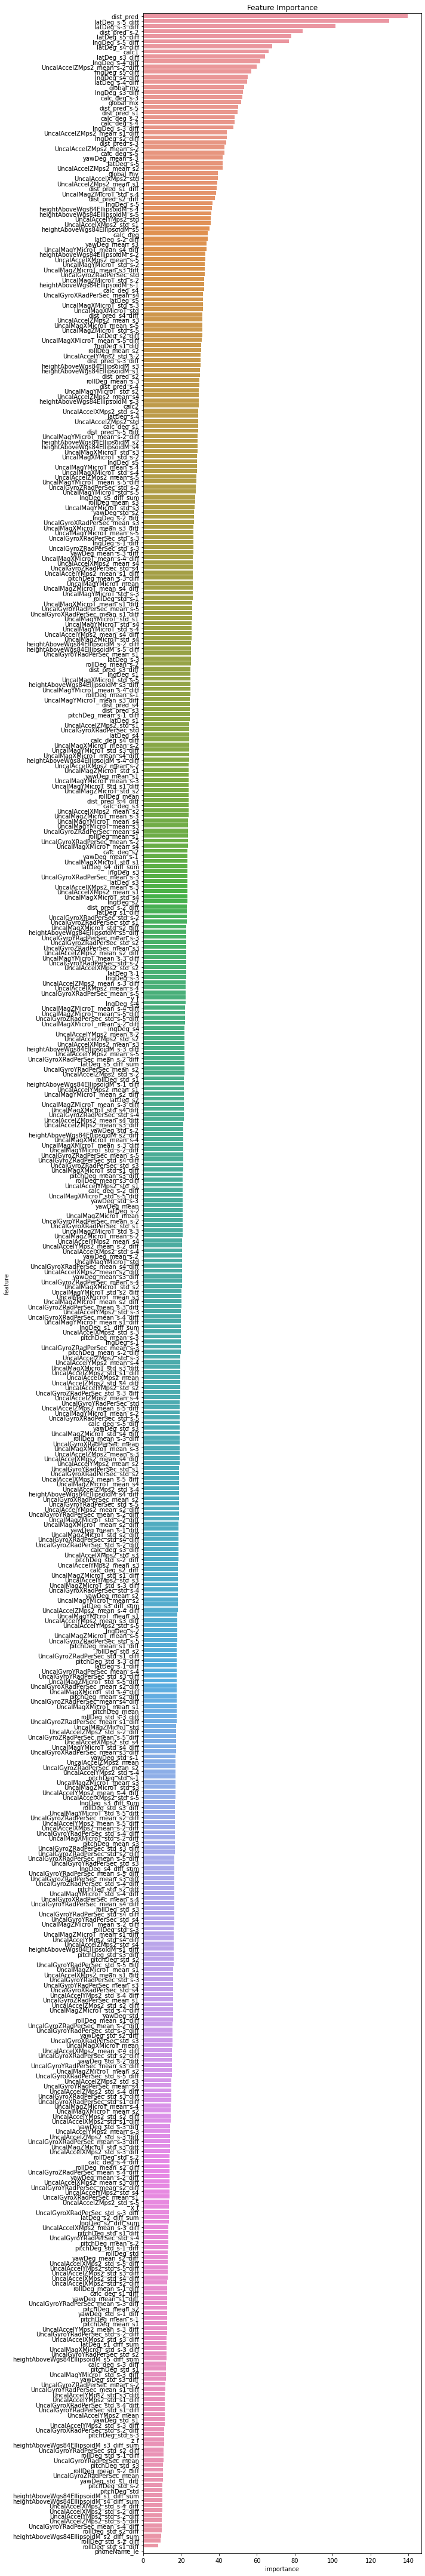

In [25]:
imp_mean = imp.groupby('feature').mean().reset_index()
plt.figure(figsize=(10, 60))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

In [29]:
oof.to_csv(OUTPUT + '/oof.csv', index=False)
test.to_csv(OUTPUT + '/test.csv', index=False)

# 評価

In [31]:
# 楕円体
ELLIPSOID_GRS80 = 1 # GRS80
ELLIPSOID_WGS84 = 2 # WGS84

# 楕円体別の長軸半径と扁平率
GEODETIC_DATUM = {
    ELLIPSOID_GRS80: [
        6378137.0,         # [GRS80]長軸半径
        1 / 298.257222101, # [GRS80]扁平率
    ],
    ELLIPSOID_WGS84: [
        6378137.0,         # [WGS84]長軸半径
        1 / 298.257223563, # [WGS84]扁平率
    ],
}

# 反復計算の上限回数
ITERATION_LIMIT = 1000

'''
Vincenty法(順解法)
始点の座標(緯度経度)と方位角と距離から、終点の座標と方位角を求める
:param lat: 緯度
:param lon: 経度
:param azimuth: 方位角
:param distance: 距離
:param ellipsoid: 楕円体
:return: 終点の座標、方位角
'''
def vincenty_direct(lat, lon, azimuth, distance, ellipsoid=None):

    # 計算時に必要な長軸半径(a)と扁平率(ƒ)を定数から取得し、短軸半径(b)を算出する
    # 楕円体が未指定の場合はGRS80の値を用いる
    a, ƒ = GEODETIC_DATUM.get(ellipsoid, GEODETIC_DATUM.get(ELLIPSOID_WGS84))
    b = (1 - ƒ) * a

    # ラジアンに変換する(距離以外)
    φ1 = radians(lat)
    λ1 = radians(lon)
    α1 = radians(azimuth)
    s = distance

    sinα1 = sin(α1)
    cosα1 = cos(α1)

    # 更成緯度(補助球上の緯度)
    U1 = atan((1 - ƒ) * tan(φ1))

    sinU1 = sin(U1)
    cosU1 = cos(U1)
    tanU1 = tan(U1)

    σ1 = atan2(tanU1, cosα1)
    sinα = cosU1 * sinα1
    cos2α = 1 - sinα ** 2
    u2 = cos2α * (a ** 2 - b ** 2) / (b ** 2)
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))

    # σをs/(b*A)で初期化
    σ = s / (b * A)

    # 以下の計算をσが収束するまで反復する
    # 地点によっては収束しないことがあり得るため、反復回数に上限を設ける
    for i in range(ITERATION_LIMIT):
        cos2σm = cos(2 * σ1 + σ)
        sinσ = sin(σ)
        cosσ = cos(σ)
        Δσ = B * sinσ * (cos2σm + B / 4 * (cosσ * (-1 + 2 * cos2σm ** 2) - B / 6 * cos2σm * (-3 + 4 * sinσ ** 2) * (-3 + 4 * cos2σm ** 2)))
        σʹ = σ
        σ = s / (b * A) + Δσ

        # 偏差が.000000000001以下ならbreak
        if abs(σ - σʹ) <= 1e-12:
            break
    else:
        # 計算が収束しなかった場合はNoneを返す
        return None

    # σが所望の精度まで収束したら以下の計算を行う
    x = sinU1 * sinσ - cosU1 * cosσ * cosα1
    φ2 = atan2(sinU1 * cosσ + cosU1 * sinσ * cosα1, (1 - ƒ) * sqrt(sinα ** 2 + x ** 2))
    λ = atan2(sinσ * sinα1, cosU1 * cosσ - sinU1 * sinσ * cosα1)
    C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
    L = λ - (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
    λ2 = L + λ1

    α2 = atan2(sinα, -x) + pi

    return {
        'lat': degrees(φ2),     # 緯度
        'lon': degrees(λ2),     # 経度
        'azimuth': degrees(α2), # 方位角
    }

In [33]:
df = oof.copy()

In [35]:
for idx in df.index:        
    if df.at[idx, 'phone'] != df.at[idx+1, 'phone']:
        continue

    lat_hat_t0 = df.at[idx, 'latDeg']
    lng_hat_t0 = df.at[idx, 'lngDeg']
    deg = df.at[idx, 'calc_deg']
    speed = df.at[idx, 'dist_pred']

    res = vincenty_direct(lat_hat_t0, lng_hat_t0, deg, speed)
    if res:
        lat_rel = res['lat']
        lng_rel = res['lon']

        df.at[idx+1, 'latDeg_diff2'] = lat_rel - lat_hat_t0
        df.at[idx+1, 'lngDeg_diff2'] = lng_rel - lng_hat_t0

KeyError: 14507

In [42]:
from sklearn.metrics import mean_squared_error
tmp = df.dropna(subset=['latDeg_diff_pred', 'latDeg_diff2'])
print('lat_ml', np.sqrt(mean_squared_error(tmp['latDeg_diff'], tmp['latDeg_diff_pred'])))
print('lat_calc', np.sqrt(mean_squared_error(tmp['latDeg_diff'], tmp['latDeg_diff2'])))
print('lng_ml', np.sqrt(mean_squared_error(tmp['lngDeg_diff'], tmp['lngDeg_diff_pred'])))
print('lng_calc', np.sqrt(mean_squared_error(tmp['lngDeg_diff'], tmp['lngDeg_diff2'])))

lat_ml 5.910202005145769e-06
lat_calc 1.6617218259043214e-05
lng_ml 8.615239134882628e-06
lng_calc 2.0269514212407214e-05
